# Lecture 7: Introduction to TensorFlow

## グラフの構築
### グラフを定義する

In [1]:
import tensorflow as tf

# バイアス作成: 値は0
b = tf.Variable(tf.zeros((100, )))
# 重み作成：値は-1～1のランダム
W = tf.Variable(tf.random_uniform((784, 100), -1, 1))

# プレースホルダーの作成
x = tf.placeholder(tf.float32, (100, 784))

# グラフの作成
h = tf.nn.relu(tf.matmul(x, W) + b)

上記プログラムは

$h = ReLU(Wx + b)$

の __式__ を示しているだけで、まだデータは流していない  
なので`h`をprintしても値は出ない  
なぜならば`x`はプレースホルダーで、実際の値ではないから

In [2]:
# グラフの基礎となるTensorFlowのクラス一覧
tf.get_default_graph().get_operations()

[<tf.Operation 'zeros' type=Const>,
 <tf.Operation 'Variable' type=VariableV2>,
 <tf.Operation 'Variable/Assign' type=Assign>,
 <tf.Operation 'Variable/read' type=Identity>,
 <tf.Operation 'random_uniform/shape' type=Const>,
 <tf.Operation 'random_uniform/min' type=Const>,
 <tf.Operation 'random_uniform/max' type=Const>,
 <tf.Operation 'random_uniform/RandomUniform' type=RandomUniform>,
 <tf.Operation 'random_uniform/sub' type=Sub>,
 <tf.Operation 'random_uniform/mul' type=Mul>,
 <tf.Operation 'random_uniform' type=Add>,
 <tf.Operation 'Variable_1' type=VariableV2>,
 <tf.Operation 'Variable_1/Assign' type=Assign>,
 <tf.Operation 'Variable_1/read' type=Identity>,
 <tf.Operation 'Placeholder' type=Placeholder>,
 <tf.Operation 'MatMul' type=MatMul>,
 <tf.Operation 'add' type=Add>,
 <tf.Operation 'Relu' type=Relu>]

### 出力を得る

In [3]:
import numpy as np

# セッション作成
sess = tf.Session()
# WやbなどのVariableの初期化
sess.run(tf.initialize_all_variables())
# グラフを評価する=計算する
sess.run(h, {x: np.random.rand(100, 784)})  # スライド間違えてる

Instructions for updating:
Use `tf.global_variables_initializer` instead.


array([[ 0.       ,  2.280098 , 13.000938 , ...,  0.       ,  0.       ,
        11.719851 ],
       [ 0.       , 10.04598  ,  6.3292704, ...,  0.       ,  0.       ,
         6.616385 ],
       [ 0.       ,  0.       , 19.495707 , ...,  0.       ,  0.       ,
        12.418323 ],
       ...,
       [ 0.       ,  0.       ,  7.4948545, ...,  0.       ,  0.       ,
         6.2408695],
       [ 0.       ,  0.       ,  8.761351 , ...,  0.       ,  0.       ,
         8.105349 ],
       [ 0.       ,  7.4930835, 12.824445 , ...,  0.       ,  0.       ,
        13.709556 ]], dtype=float32)

```python
sess.run(fetch, feeds)
```

__fetch__: 構築したグラフのリスト  
__feeds__: グラフに入力する具体的な値がマッピングされた辞書

## 学習モデルを作る
### lossについて

サンプルコード
```python
prediction = tf.nn.softmax(...)  # ニューラルネットの出力
label = tf.placeholder(tf.float32, [100, 10])

# labelはonehotな行列なので、predictionと乗算すると、負例は0となり、正例のlossとなる
cross_entropy = -tf.reduce_sum(label * tf.log(prediction), axis=1)

# 最適化手法を定義
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)  # lr=0.5
```

### モデルを学習させる

サンプルコード
```python
sess = tf.Session()
sess.run(tf.initialize_all_variables())

# 1,000イテレーション学習する
for  i in range(1000):
    # データからバッチを取り出す
    batch_x, batch_label = data.next_batch()
    # バッチごとに最適化手法を走らせる
    sess.run(train_step, feed_dict={
            x: batch_x
            label: batch_label
        })
```

### 複数GPUでVariableを共有する場合

In [8]:
# 悪い例: コードがごちゃる
variable_dict = {
    "weight": tf.Variable(tf.random_normal([784, 100]), name="weights"),
    "biases": tf.Variable(tf.zeros([100]), name="biases")
}

名前空間の衝突を避けるために`tf.variable_scope`で定義されたスコープ内で`tf.get_variable`を使ってvariableを作成したりアクセスしたりする

fooというスコープで、variable`v`を定義
```python
with tf.variable_scope("foo"):
    v = tf.get_variable("v", shape=[1])
```

fooのスコープ内で`reuse=True`にしていると再利用可能

```python
with tf.variable_scope("foo", reuse=True):
    v1 = tf.get_variable("v")
```

`reuse=Fales`だと、fooの中でvは`already exist`と怒られる
```python
with tf.variable_scope("foo", reuse=False):
    v1 = tf.get_variable("v")
```

## モデル実装
### 線形回帰モデル作成

In [12]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def generate_dataset():
    """
    y = 2x + e から作られる
    eは正規分布で定義される
    """
    x_batch = np.linspace(-1, 1, 101)
    y_batch = 2 * x_batch + np.random.randn(*x_batch.shape) * 0.3
    return x_batch, y_batch 

In [31]:
def linear_regression():
    # shapeにNoneを設定すると、バッチサイズに応じて動的に対応できる
    x =  tf.placeholder(tf.float32, shape=(None, ), name='x')
    y =  tf.placeholder(tf.float32, shape=(None, ), name='y')
    
    with tf.variable_scope("lreg", reuse=True) as scope:
        w = tf.Variable(np.random.normal(), name='W')
        y_pred = tf.multiply(w, x)  # mulはv0.xのもので、v1.0以上では廃止
        
        loss = tf.reduce_mean(tf.square(y_pred - y))
    return x, y, y_pred, loss

In [32]:
def run():
    x_batch, y_batch = generate_dataset()
    
    x, y, y_pred, loss = linear_regression()
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

    init = tf.global_variables_initializer()
    with tf.Session() as session:
        session.run(init)
        
        feed_dict = {x: x_batch, y:y_batch}
        for _ in range(30):
            loss_val, _ = session.run([loss, optimizer], feed_dict)
            print('loss:', loss_val.mean())
        
        y_pred_batch = session.run(y_pred, {x: x_batch})
    plt.figure(1)
    plt.scatter(x_batch, y_batch)
    plt.plot(x_batch, y_pred_batch)

loss: 2.8755486
loss: 2.5110216
loss: 2.1943848
loss: 1.9193462
loss: 1.6804415
loss: 1.4729229
loss: 1.2926674
loss: 1.136093
loss: 1.0000888
loss: 0.8819523
loss: 0.779336
loss: 0.6902011
loss: 0.6127764
loss: 0.5455234
loss: 0.48710585
loss: 0.43636295
loss: 0.39228648
loss: 0.35400057
loss: 0.3207445
loss: 0.29185754
loss: 0.2667656
loss: 0.24497013
loss: 0.22603807
loss: 0.20959322
loss: 0.19530885
loss: 0.18290108
loss: 0.1721234
loss: 0.16276164
loss: 0.15462981
loss: 0.14756632


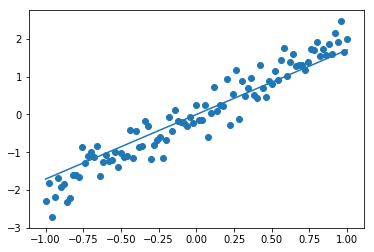

In [33]:
run()

### word2vecモデル

In [36]:
import math
batch_size = 128
vocabulary_size = 50000
embedding_size = 128
num_sampled = 64

In [40]:
def skipgram():
    batch_inputs = tf.placeholder(tf.int32, shape=[batch_size,])
    batch_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    val_dataset = tf.constant(val_data, dtype=tf.int32)
    
    with tf.variable_scope("word2vec") as scope:
        embeddings = tf.Variable(tf.random_uniform([vocabulary_size,
                                                    embedding_size],
                                                  -1.0, 1.0))
        # Variableの一部のみ学習させたいときに使用。ここではバッチ内の重みだけ学習するようにしている
        batch_embeddings = tf.nn.embedding_lookup(embeddings, batch_inputs)
        
        # 重みは切断正規分布を使う
        weights = tf.Variable(tf.truncated_normal([vocabulary_size,
                                                   embedding_size],
                                                   stddev = 1.0/math.sqrt(embedding_size)))
        biases = tf.Variable(tf.zeros([vocabulary_size]))
        
        loss = tf.reduce_mean(tf.nn.nec_loss(weights=weights,
                                             biases=biases,
                                             labels=batch_labels,
                                             inputs=batch_inputs,
                                             num_sampled=num_sampled,
                                             num_classes=vocabulary_size))
        norm = tf.sqrt(tf.reduce_mean(tf.square(embeddings), 1, keep_dims=True))
        normalized_embeddings = embeddings / norm
        
        val_embeddings = tf.nn.embedding_lookup(normalized_embeddings, val_dataset)
        similarity = tf.matmul(val_embeddings, normalized_embeddings, loss, similarity)
        return batch_inputs, batch_labels, normalized_embeddings, loss, similarity

In [41]:
def run():
    batch_inputs, batch_labels, normalized_embeddings, loss, similarity = skipgram()
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        
        average_loss = 0.0
        for step, batch_data in enumerate(train_data):
            inputs, labels = batch_data
            feed_dict = {batch_inputs: inputs, batch_labels: labels}
            
            _, loss_val = session.run([optimizer, loss], feed_dict)
            average_loss += loss_val
            if step % 1000 == 0:
                if step > 0:
                    average_loss /= 1000
                print('loss at iter', step, ':', average_loss)
                average_loss = 0
                
            if step % 5000 == 0:
                sim = similarity.eval()
                for i in range(len(val_data)):  # 多分講義ではpython2系で実装してる？
                    top_k = 8
                    nearest = (sim[i,:]).argsort()[1:top_k-1]
                    print_closest_words(val_data[i], nearst)

In [ ]:
final